# Part 0: Load in libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from scipy.stats import fisher_exact


# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Get and Analyze IDR clusters

## 1.1 - Load in IDR information

In [2]:
humandf=pd.read_excel('../general_data/All_sapiens_IDRs_clustermap_using_centroids.xlsx')

print(humandf.isnull().any())
humandf = humandf.fillna('')

fullaccs=humandf['Uniprot'].tolist()
fullaccswnums=humandf['Uniprot w IDRnum'].tolist()
fullgeneswnums=humandf['Gene'].tolist()
fullclusternum=humandf['Cluster Number'].tolist()
fullseqlens=humandf['IDR Length'].tolist()
fullstpos=humandf['Start Pos'].tolist()
fullenpos=humandf['End Pos'].tolist()
fullproteinlength=humandf['Full Protein Length'].tolist()
fullmininterclustdist=humandf['Min Inter Clust Dist'].tolist()
fulltermini=humandf['IDR Position'].tolist()
fulllocationbyunistring=humandf['HPA Location'].tolist()
fullseqs=humandf['Sequence'].tolist()

print(humandf)


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
1               1  Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17   
2               2  Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1   
3               3  Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27   
4               4  Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27   
...           ...     ...              ...             ...             ...   
24503       24503  Q7Z739         Q7Z739_2     YTHDF

## 1.2 - Load in IDR z-score data

In [3]:
# make sure features match
myfeat=['pol-pol','pol-hyd','pol-pos','pol-neg','pol-aro','pol-ala','pol-pro','pol-gly','hyd-hyd','hyd-pos','hyd-neg','hyd-aro','hyd-ala','hyd-pro','hyd-gly','pos-pos','pos-neg','pos-aro','pos-ala','pos-pro','pos-gly','neg-neg','neg-aro','neg-ala','neg-pro','neg-gly','aro-aro','aro-ala','aro-pro','aro-gly','ala-ala','ala-pro','ala-gly','pro-pro','pro-gly','gly-gly','Frac A','Frac C','Frac D','Frac E','Frac F','Frac G','Frac H','Frac I','Frac K','Frac L','Frac M','Frac N','Frac P','Frac Q','Frac R','Frac S','Frac T','Frac V','Frac W','Frac Y','Frac K+R','Frac D+E','Frac Polar','Frac Aliphatic','Frac Aromatic','R/K Ratio','E/D Ratio','Frac Chain Expanding','FCR','NCPR','Hydrophobicity','Disorder Promoting','Iso point','PPII','A Patch','C Patch','D Patch','E Patch','F Patch','G Patch','H Patch','I Patch','K Patch','L Patch','M Patch','N Patch','P Patch','Q Patch','R Patch','S Patch','T Patch','V Patch','Y Patch','RG Frac']
print(len(myfeat))

# Load in z-scores for all human IDRs
# Made in /project/fava/work/kiersten.ruff/Collaborations/Su/2023/Library_design/map_clusters_for_all_human_IDRs.ipynb
fullzvec=np.load('../general_data/sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')
print(fullzvec.shape)

90
(24508, 90)


## 1.3 - Create subset of IDRs that want to analyze - all IDRs length gte 70 and non-linker IDRs gte 50 in length and min inter cluster distance gte 1.5

In [4]:
minidrlength=50
minidrlinkerlength=70
mininterclustdist=1.5

subidrsdf=humandf[humandf['IDR Length']>=minidrlength]
subidrsdf=subidrsdf[ (subidrsdf['IDR Length']>=minidrlinkerlength) | (subidrsdf['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]
subidrsdf=subidrsdf[subidrsdf['Min Inter Clust Dist']>=mininterclustdist]
print(subidrsdf.isnull().any())
subidrsdf = subidrsdf.fillna('')
print(subidrsdf)

subaccs=subidrsdf['Uniprot'].tolist()
subaccswnums=subidrsdf['Uniprot w IDRnum'].tolist()
subgeneswnums=subidrsdf['Gene'].tolist()
subclusters=subidrsdf['Cluster Number'].tolist()
subseqlens=subidrsdf['IDR Length'].tolist()
substpos=subidrsdf['Start Pos'].tolist()
subenpos=subidrsdf['End Pos'].tolist()
subproteinlength=subidrsdf['Full Protein Length'].tolist()
submininterclustdist=subidrsdf['Min Inter Clust Dist'].tolist()
subtermini=subidrsdf['IDR Position'].tolist()
subseqs=subidrsdf['Sequence'].tolist()
sublocstring=subidrsdf['HPA Location'].tolist()


sublocationbyunistring=sublocstring


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location            False
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
7               7  Q9NRJ4         Q9NRJ4_7      TULP4 IDR7              23   
8               8  Q5MIZ7         Q5MIZ7_1    PPP4R3B IDR1              18   
12             12  Q9NQ76         Q9NQ76_1       MEPE IDR1               4   
14             14  Q9NQ76         Q9NQ76_3       MEPE IDR3              24   
...           ...     ...              ...             ...             ...   
24495       24495  Q6ZSZ5         Q6ZSZ5_1   ARHGEF1

## 1.3b - Create subset of IDRs that want to analyze - all IDRs length gte 70 and non-linker IDRs gte 50 in length - used when don't care about cluster distance

In [5]:
subidrsdfNODIST=humandf[humandf['IDR Length']>=minidrlength]
subidrsdfNODIST=subidrsdfNODIST[ (subidrsdfNODIST['IDR Length']>=minidrlinkerlength) | (subidrsdfNODIST['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]
print(subidrsdfNODIST.isnull().any())
subidrsdfNODIST = subidrsdfNODIST.fillna('')
print(subidrsdfNODIST)

subaccsNODIST=subidrsdfNODIST['Uniprot'].tolist()
subaccswnumsNODIST=subidrsdfNODIST['Uniprot w IDRnum'].tolist()
subgeneswnumsNODIST=subidrsdfNODIST['Gene'].tolist()
subclustersNODIST=subidrsdfNODIST['Cluster Number'].tolist()
subseqlensNODIST=subidrsdfNODIST['IDR Length'].tolist()
substposNODIST=subidrsdfNODIST['Start Pos'].tolist()
subenposNODIST=subidrsdfNODIST['End Pos'].tolist()
subproteinlengthNODIST=subidrsdfNODIST['Full Protein Length'].tolist()
submininterclustdistNODIST=subidrsdfNODIST['Min Inter Clust Dist'].tolist()
subterminiNODIST=subidrsdfNODIST['IDR Position'].tolist()
subseqsNODIST=subidrsdfNODIST['Sequence'].tolist()
sublocstringNODIST=subidrsdfNODIST['HPA Location'].tolist()


sublocationbyunistringNODIST=sublocstringNODIST

Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location            False
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
7               7  Q9NRJ4         Q9NRJ4_7      TULP4 IDR7              23   
8               8  Q5MIZ7         Q5MIZ7_1    PPP4R3B IDR1              18   
12             12  Q9NQ76         Q9NQ76_1       MEPE IDR1               4   
14             14  Q9NQ76         Q9NQ76_3       MEPE IDR3              24   
...           ...     ...              ...             ...             ...   
24498       24498  Q6ZSZ5         Q6ZSZ5_4   ARHGEF1

# Part 2 - Analyze Ribosomal Biogenesis IDRs

## 2.1 - Determine if have cluster 7, 18, or 23 IDRs in each ribosomal biogenesis protein

In [43]:
rbdf=pd.read_excel('data/Ribosomal_biogeneis_factors.xlsx',sheet_name='All_biogenesis_factors')
print(rbdf)

rbaccs=rbdf['Accession'].tolist()

rbhasIDR=[]
rbclustertypes=[]
rb7=[]
rb18=[]
rb23=[]
rb71823=[]
for s in range(0,len(rbaccs)):
    pos=[i for i, x in enumerate(subaccsNODIST) if x == rbaccs[s]]
    if not pos:
        rbhasIDR.append('No')
        rb7.append('No')
        rb18.append('No')
        rb23.append('No')
        rb71823.append('No')
    else:
        rbhasIDR.append('Yes')
        tmplist=[]
        for p in pos:
            tmplist.append(subclustersNODIST[p])
        #print(subgeneswnumsNODIST[p])
        #print(tmplist)
        
        if 7 in tmplist:
            rb7.append('Yes')
        else:
            rb7.append('No')
            
        if 18 in tmplist:
            rb18.append('Yes')
        else:
            rb18.append('No')
                        
        if 23 in tmplist:
            rb23.append('Yes')
        else:
            rb23.append('No')
            
        if 7 in tmplist or 18 in tmplist or 23 in tmplist:
            rb71823.append('Yes')
        else:
            rb71823.append('No')

rbdfwclust=rbdf
rbdfwclust['IDR']=rbhasIDR
rbdfwclust['Cluster 7']=rb7
rbdfwclust['Cluster 18']=rb18
rbdfwclust['Cluster 23']=rb23
rbdfwclust['Cluster 7, 18, or 23']=rb71823

print(rbdfwclust)

#rbdfwclust.to_excel('data/Ribosomal_biogeneis_factors_w_clusters.xlsx')

    Accession    Gene                                General Process  \
0      P19388  POLR2E                             rDNA Transcription   
1      P61218  POLR2F                             rDNA Transcription   
2      P52434  POLR2H                             rDNA Transcription   
3      P62875  POLR2L                             rDNA Transcription   
4      P53803  POLR2K                             rDNA Transcription   
..        ...     ...                                            ...   
269    Q92499    DDX1  Other factors involved in ribosome biogenesis   
270    Q9ULT8  HECTD1  Other factors involved in ribosome biogenesis   
271    Q9P275   USP36  Other factors involved in ribosome biogenesis   
272    O95071    UBR5  Other factors involved in ribosome biogenesis   
273    Q9Y4B6   DCAF1  Other factors involved in ribosome biogenesis   

                      Category  
0    RNA Polymerase I subunits  
1    RNA Polymerase I subunits  
2    RNA Polymerase I subunits  
3  

## 2.2 - Determine number of discreate processes with 7, 18, 23 or any

In [44]:
cccategory=rbdfwclust['Category'].tolist()
ccgeneralprocess=rbdfwclust['General Process'].tolist()

uniccgeneralprocess=[]
unicccategory=[]
for s in range(0,len(ccgeneralprocess)):
    if ccgeneralprocess[s] not in uniccgeneralprocess:
        uniccgeneralprocess.append(ccgeneralprocess[s])
    if cccategory[s] not in unicccategory:
        unicccategory.append(cccategory[s])
print(len(unicccategory))

colnames=['Cluster 7','Cluster 18','Cluster 23','Cluster 7, 18, or 23']
haveclustmain=[0]*len(colnames)
#print(haveclustmain)
for i in range(0,len(unicccategory)):
    dftmp=rbdfwclust[rbdfwclust['Category']==unicccategory[i]]
    #print(dftmp)
    for j in range(0,len(colnames)):
        tmplist=dftmp[colnames[j]].tolist()
        if 'Yes' in tmplist:
            haveclustmain[j]=haveclustmain[j]+1
            
print(haveclustmain)
haveclustmainfrac=[]
for i in range(0,len(colnames)):
    haveclustmainfrac.append(haveclustmain[i]/len(unicccategory))
print(haveclustmainfrac)

42
[17, 12, 30, 35]
[0.40476190476190477, 0.2857142857142857, 0.7142857142857143, 0.8333333333333334]


## 2.3 - Determine which GIN type IDRs in each ribosomal biogenesis protein

In [45]:
numkclusts=max(fullclusternum)+1

rbdf=pd.read_excel('data/Ribosomal_biogeneis_factors.xlsx',sheet_name='All_biogenesis_factors')
#print(rbdf)

rbaccs=rbdf['Accession'].tolist()

rbhasIDR=[]
rbclustertypes=[]
rbc=[[] for _ in range(numkclusts)]
for s in range(0,len(rbaccs)):
    pos=[i for i, x in enumerate(subaccsNODIST) if x == rbaccs[s]]
    if not pos:
        rbhasIDR.append('No')
        for i in range(0,numkclusts):
            rbc[i].append('No')
        
    else:
        rbhasIDR.append('Yes')

        tmplist=[]
        for p in pos:
            tmplist.append(subclustersNODIST[p])
        #print(subgeneswnumsNODIST[p])
        #print(tmplist)
        
        for i in range(0,numkclusts):
            if i in tmplist:
                rbc[i].append('Yes')
            else:
                rbc[i].append('No')


rbdfallclust=rbdf
rbdfallclust['IDR']=rbhasIDR
for i in range(0,numkclusts):
    rbdfallclust['Cluster '+str(i)]=rbc[i]
    

print(rbdfallclust)

    Accession    Gene                                General Process  \
0      P19388  POLR2E                             rDNA Transcription   
1      P61218  POLR2F                             rDNA Transcription   
2      P52434  POLR2H                             rDNA Transcription   
3      P62875  POLR2L                             rDNA Transcription   
4      P53803  POLR2K                             rDNA Transcription   
..        ...     ...                                            ...   
269    Q92499    DDX1  Other factors involved in ribosome biogenesis   
270    Q9ULT8  HECTD1  Other factors involved in ribosome biogenesis   
271    Q9P275   USP36  Other factors involved in ribosome biogenesis   
272    O95071    UBR5  Other factors involved in ribosome biogenesis   
273    Q9Y4B6   DCAF1  Other factors involved in ribosome biogenesis   

                      Category  IDR Cluster 0 Cluster 1 Cluster 2 Cluster 3  \
0    RNA Polymerase I subunits   No        No        No 

## 2.4 - Determine number of discreate processes with each IDR GIN type

['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'Cluster 12', 'Cluster 13', 'Cluster 14', 'Cluster 15', 'Cluster 16', 'Cluster 17', 'Cluster 18', 'Cluster 19', 'Cluster 20', 'Cluster 21', 'Cluster 22', 'Cluster 23', 'Cluster 24', 'Cluster 25', 'Cluster 26', 'Cluster 27', 'Cluster 28', 'Cluster 29']
[4, 0, 0, 1, 5, 7, 3, 17, 5, 7, 0, 3, 9, 5, 2, 1, 3, 10, 12, 5, 1, 1, 1, 30, 3, 5, 5, 1, 7, 3]
[0.09523809523809523, 0.0, 0.0, 0.023809523809523808, 0.11904761904761904, 0.16666666666666666, 0.07142857142857142, 0.40476190476190477, 0.11904761904761904, 0.16666666666666666, 0.0, 0.07142857142857142, 0.21428571428571427, 0.11904761904761904, 0.047619047619047616, 0.023809523809523808, 0.07142857142857142, 0.23809523809523808, 0.2857142857142857, 0.11904761904761904, 0.023809523809523808, 0.023809523809523808, 0.023809523809523808, 0.7142857142857143, 0.07142857142857142, 0.1190476190

(array([10., 12.,  3.,  2.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
        0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
        0.71428571]),
 <BarContainer object of 10 artists>)

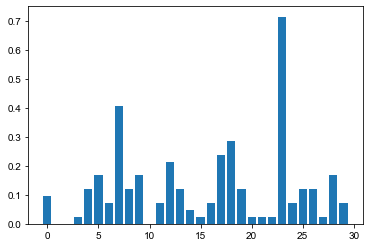

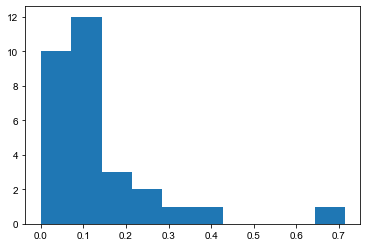

In [46]:
cccategory=rbdfallclust['Category'].tolist()
ccgeneralprocess=rbdfallclust['General Process'].tolist()

uniccgeneralprocess=[]
unicccategory=[]
for s in range(0,len(ccgeneralprocess)):
    if ccgeneralprocess[s] not in uniccgeneralprocess:
        uniccgeneralprocess.append(ccgeneralprocess[s])
    if cccategory[s] not in unicccategory:
        unicccategory.append(cccategory[s])

colnames=rbdfallclust.columns.tolist()[5:]
print(colnames)

haveclust=[0]*len(colnames)
for i in range(0,len(unicccategory)):
    dftmp=rbdfallclust[rbdfallclust['Category']==unicccategory[i]]
    #print(dftmp)
    for j in range(0,len(colnames)):
        tmplist=dftmp[colnames[j]].tolist()
        if 'Yes' in tmplist:
            haveclust[j]=haveclust[j]+1
            
print(haveclust)
haveclustfrac=[]
for i in range(0,len(colnames)):
    haveclustfrac.append(haveclust[i]/len(unicccategory))
print(haveclustfrac)

plt.bar(np.arange(0,numkclusts,1),haveclustfrac)

print(scipy.stats.binom_test(haveclust[23], 42, p=np.mean(haveclustfrac)))
print(scipy.stats.binom_test(haveclust[7], 42, p=np.mean(haveclustfrac)))
print(scipy.stats.binom_test(haveclust[18], 42, p=np.mean(haveclustfrac)))

plt.figure()
plt.hist(haveclustfrac)


## 2.5 - Determine number of discreate processes with any 3 IDR cluster type

In [53]:
cccategory=rbdfallclust['Category'].tolist()
ccgeneralprocess=rbdfallclust['General Process'].tolist()

uniccgeneralprocess=[]
unicccategory=[]
for s in range(0,len(ccgeneralprocess)):
    if ccgeneralprocess[s] not in uniccgeneralprocess:
        uniccgeneralprocess.append(ccgeneralprocess[s])
    if cccategory[s] not in unicccategory:
        unicccategory.append(cccategory[s])

#colnames=rbdfallclust.columns.tolist()[5:]
allcolnames=rbdfallclust.columns.tolist()[5:]
subcolnames=['Cluster 7','Cluster 18','Cluster 23']
colnames = [x for x in allcolnames if x not in subcolnames]
print(colnames)

haveclust=[0]*int(math.factorial(len(colnames))/(math.factorial(len(colnames)-3)*math.factorial(3)))
setnames=[]
print(len(haveclust))
for i in range(0,len(unicccategory)):
    dftmp=rbdfallclust[rbdfallclust['Category']==unicccategory[i]]
    #print(dftmp)
    count=-1
    for j in range(0,len(colnames)):
        for k in range(j+1,len(colnames)):
            for l in range(k+1,len(colnames)):
                count=count+1
                tmplist1=dftmp[colnames[j]].tolist()
                tmplist2=dftmp[colnames[k]].tolist()
                tmplist3=dftmp[colnames[l]].tolist()
                if i==0:
                    setnames.append(colnames[j]+', '+colnames[k]+', '+colnames[l])
                #print(str(i)+': '+str(count))
                if 'Yes' in tmplist1 or 'Yes' in tmplist2 or 'Yes' in tmplist3:
                    haveclust[count]=haveclust[count]+1
                
#print(haveclust)
print(max(haveclust))
print(np.mean(haveclust))

haveclustfrac=[]
for i in range(0,len(haveclust)):
    haveclustfrac.append(haveclust[i]/len(unicccategory))
print(np.mean(haveclustfrac))

myval=scipy.stats.ttest_ind([35, 35, 35], haveclust)
myval2=scipy.stats.binom_test(35, 42, p=np.mean(haveclustfrac))
print(myval)
print(myval2)

myzscore=((35/42)-np.mean(haveclustfrac))/np.std(haveclustfrac)
print('z-score = '+str(round(myzscore,2)))

print(len(haveclustfrac))
print(len(setnames))


['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'Cluster 12', 'Cluster 13', 'Cluster 14', 'Cluster 15', 'Cluster 16', 'Cluster 17', 'Cluster 19', 'Cluster 20', 'Cluster 21', 'Cluster 22', 'Cluster 24', 'Cluster 25', 'Cluster 26', 'Cluster 27', 'Cluster 28', 'Cluster 29']
2925
20
9.19897435897436
0.219023199023199
Ttest_indResult(statistic=12.911528839717365, pvalue=3.926224258748268e-37)
4.1759424429302515e-17
z-score = 7.46
2925
2925


## 2.6 - Plot distribution of number of occurences

(-0.05, 1.05)

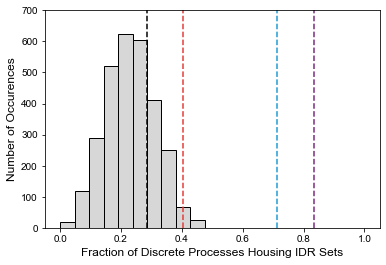

In [54]:
plt.hist(haveclustfrac,color='#d7d7d7',edgecolor='black')

mycolor=['#e23c36','#000000','#1d9bd7','#7c2880']
for i in range(0,len(haveclustmainfrac)):
    plt.plot([haveclustmainfrac[i],haveclustmainfrac[i]],[0,700],'--',color=mycolor[i])
    
plt.ylim([0,700])
plt.ylabel('Number of Occurences',fontsize=12)
plt.xlabel('Fraction of Discrete Processes Housing IDR Sets',fontsize=12)
plt.xlim([-0.05, 1.05])
#plt.savefig('Figures/2024_02/nucleolus/Fraction_discrete_ribosome_biogenesis_processes_housing_3_IDR_sets_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'.pdf', transparent=True, bbox_inches = "tight") 


## 2.7 - Save data to excel file

In [55]:
setnames.append('Cluster 7')
setnames.append('Cluster 18')
setnames.append('Cluster 23')
setnames.append('Cluster 7, Cluster 18, Cluster 23')

haveclustfracall=haveclustfrac.copy()
for i in range(0,len(haveclustmainfrac)):
    haveclustfracall.append(haveclustmainfrac[i])

print(len(haveclustfrac))
print(len(haveclustfracall))
    
tmpdf=pd.DataFrame()
tmpdf['Which Clusters']=setnames
tmpdf['Fraction of Processes']=haveclustfracall
print(tmpdf)

#with pd.ExcelWriter('../Supplementary_Tables/Table_S2.xlsx', engine='openpyxl',mode='a') as writer:
#    tmpdf.to_excel(writer,sheet_name='Fig_S2E')

2925
2929
                          Which Clusters  Fraction of Processes
0        Cluster 0, Cluster 1, Cluster 2               0.095238
1        Cluster 0, Cluster 1, Cluster 3               0.119048
2        Cluster 0, Cluster 1, Cluster 4               0.190476
3        Cluster 0, Cluster 1, Cluster 5               0.238095
4        Cluster 0, Cluster 1, Cluster 6               0.142857
...                                  ...                    ...
2924  Cluster 27, Cluster 28, Cluster 29               0.261905
2925                           Cluster 7               0.404762
2926                          Cluster 18               0.285714
2927                          Cluster 23               0.714286
2928   Cluster 7, Cluster 18, Cluster 23               0.833333

[2929 rows x 2 columns]


In [52]:
print((math.factorial(len(colnames))/(math.factorial(len(colnames)-3)*math.factorial(3))))

totfrac=(763+413+1043)/24508
print(totfrac)

4060.0
0.09054186388118166


# Part 3 - Analyze Spliceosome IDRs

## 3.1 - Determine if have cluster 18, or 26 IDRs in each ribosomal biogenesis protein

In [56]:
nsdf=pd.read_excel('data/Nuclear_speckles_complexes.xlsx',sheet_name='Nuclear_speckle_processes')
print(nsdf)


nsaccs=nsdf['Accession'].tolist()

nshasIDR=[]
nsclustertypes=[]
ns18=[]
ns26=[]
ns1826=[]
for s in range(0,len(nsaccs)):
    pos=[i for i, x in enumerate(subaccsNODIST) if x == nsaccs[s]]
    if not pos:
        nshasIDR.append('No')
        ns18.append('No')
        ns26.append('No')
        ns1826.append('No')
    else:
        nshasIDR.append('Yes')
        tmplist=[]
        for p in pos:
            tmplist.append(subclustersNODIST[p])
        #print(subgeneswnumsNODIST[p])
        #print(tmplist)
        
            
        if 18 in tmplist:
            ns18.append('Yes')
        else:
            ns18.append('No')
                        
        if 26 in tmplist:
            ns26.append('Yes')
        else:
            ns26.append('No')
            
        if 18 in tmplist or 26 in tmplist:
            ns1826.append('Yes')
        else:
            ns1826.append('No')

nsdfwclust=nsdf
nsdfwclust['IDR']=nshasIDR
nsdfwclust['Cluster 18']=ns18
nsdfwclust['Cluster 26']=ns26
nsdfwclust['Cluster 18, or 26']=ns1826

print(ns18.count('Yes'))
print(ns26.count('Yes'))

print(nsdfwclust)

#nsdfwclust.to_excel('data/Nuclear_speckles_complexes_w_clusters_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'.xlsx')

    Accession     Gene    General Process                         Category
0      Q13838   DDX39B  Major Spliceosome           Spliceosomal E complex
1      Q15637      SF1  Major Spliceosome           Spliceosomal E complex
2      Q01081    U2AF1  Major Spliceosome           Spliceosomal E complex
3      P26368    U2AF2  Major Spliceosome           Spliceosomal E complex
4      Q8IX12    CCAR1  Major Spliceosome           Spliceosomal A complex
..        ...      ...                ...                              ...
526    P52739   ZNF131   Splicing factors  Other pre-mRNA splicing factors
527    O43670   ZNF207   Splicing factors  Other pre-mRNA splicing factors
528    Q5BKZ1   ZNF326   Splicing factors  Other pre-mRNA splicing factors
529    Q9UL40   ZNF346   Splicing factors  Other pre-mRNA splicing factors
530    Q15695  ZRSR2P1   Splicing factors  Other pre-mRNA splicing factors

[531 rows x 4 columns]
48
92
    Accession     Gene    General Process                         Cate

## 3.2 - Determine number of discreate processes with 18, 26 or any

In [57]:
cccategory=nsdfwclust['Category'].tolist()
ccgeneralprocess=nsdfwclust['General Process'].tolist()

uniccgeneralprocess=[]
unicccategory=[]
for s in range(0,len(ccgeneralprocess)):
    if ccgeneralprocess[s] not in uniccgeneralprocess:
        uniccgeneralprocess.append(ccgeneralprocess[s])
    if cccategory[s] not in unicccategory:
        unicccategory.append(cccategory[s])
print(len(unicccategory))

colnames=['Cluster 18','Cluster 26','Cluster 18, or 26']
haveclustmain=[0]*len(colnames)
#print(haveclustmain)
for i in range(0,len(unicccategory)):
    dftmp=nsdfwclust[nsdfwclust['Category']==unicccategory[i]]
    #print(dftmp)
    for j in range(0,len(colnames)):
        tmplist=dftmp[colnames[j]].tolist()
        if 'Yes' in tmplist:
            haveclustmain[j]=haveclustmain[j]+1
            
print(haveclustmain)
haveclustmainfrac=[]
for i in range(0,len(colnames)):
    haveclustmainfrac.append(haveclustmain[i]/len(unicccategory))
print(haveclustmainfrac)

24
[15, 15, 18]
[0.625, 0.625, 0.75]


## 3.3 - Determine which IDRs in each spliceosome protein

In [58]:
numkclusts=max(fullclusternum)+1

nsdf=pd.read_excel('data/Nuclear_speckles_complexes.xlsx',sheet_name='Nuclear_speckle_processes')
print(nsdf)

nsaccs=nsdf['Accession'].tolist()


nshasIDR=[]
nsclustertypes=[]
nsc=[[] for _ in range(numkclusts)]
for s in range(0,len(nsaccs)):
    pos=[i for i, x in enumerate(subaccsNODIST) if x == nsaccs[s]]
    if not pos:
        nshasIDR.append('No')
        for i in range(0,numkclusts):
            nsc[i].append('No')
        
    else:
        nshasIDR.append('Yes')

        tmplist=[]
        for p in pos:
            tmplist.append(subclustersNODIST[p])
        #print(subgeneswnumsNODIST[p])
        #print(tmplist)
        
        for i in range(0,numkclusts):
            if i in tmplist:
                nsc[i].append('Yes')
            else:
                nsc[i].append('No')


nsdfallclust=nsdf
nsdfallclust['IDR']=nshasIDR
for i in range(0,numkclusts):
    nsdfallclust['Cluster '+str(i)]=nsc[i]
    

print(nsdfallclust)

    Accession     Gene    General Process                         Category
0      Q13838   DDX39B  Major Spliceosome           Spliceosomal E complex
1      Q15637      SF1  Major Spliceosome           Spliceosomal E complex
2      Q01081    U2AF1  Major Spliceosome           Spliceosomal E complex
3      P26368    U2AF2  Major Spliceosome           Spliceosomal E complex
4      Q8IX12    CCAR1  Major Spliceosome           Spliceosomal A complex
..        ...      ...                ...                              ...
526    P52739   ZNF131   Splicing factors  Other pre-mRNA splicing factors
527    O43670   ZNF207   Splicing factors  Other pre-mRNA splicing factors
528    Q5BKZ1   ZNF326   Splicing factors  Other pre-mRNA splicing factors
529    Q9UL40   ZNF346   Splicing factors  Other pre-mRNA splicing factors
530    Q15695  ZRSR2P1   Splicing factors  Other pre-mRNA splicing factors

[531 rows x 4 columns]
    Accession     Gene    General Process                         Category  

## 3.4 - Determine number of discreate processes with each IDR cluster type

['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'Cluster 12', 'Cluster 13', 'Cluster 14', 'Cluster 15', 'Cluster 16', 'Cluster 17', 'Cluster 18', 'Cluster 19', 'Cluster 20', 'Cluster 21', 'Cluster 22', 'Cluster 23', 'Cluster 24', 'Cluster 25', 'Cluster 26', 'Cluster 27', 'Cluster 28', 'Cluster 29']
[5, 12, 3, 2, 2, 3, 3, 9, 1, 6, 3, 2, 5, 6, 5, 2, 1, 3, 15, 8, 8, 2, 1, 8, 7, 5, 15, 5, 2, 6]
[0.20833333333333334, 0.5, 0.125, 0.08333333333333333, 0.08333333333333333, 0.125, 0.125, 0.375, 0.041666666666666664, 0.25, 0.125, 0.08333333333333333, 0.20833333333333334, 0.25, 0.20833333333333334, 0.08333333333333333, 0.041666666666666664, 0.125, 0.625, 0.3333333333333333, 0.3333333333333333, 0.08333333333333333, 0.041666666666666664, 0.3333333333333333, 0.2916666666666667, 0.20833333333333334, 0.625, 0.20833333333333334, 0.08333333333333333, 0.25]
0.0366727506983007
0.0366727506983007


(array([9., 5., 5., 3., 4., 1., 0., 1., 0., 2.]),
 array([0.04166667, 0.1       , 0.15833333, 0.21666667, 0.275     ,
        0.33333333, 0.39166667, 0.45      , 0.50833333, 0.56666667,
        0.625     ]),
 <BarContainer object of 10 artists>)

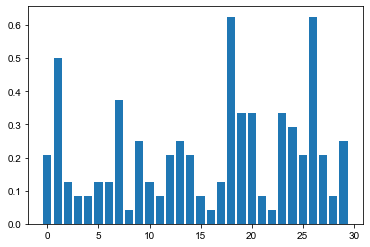

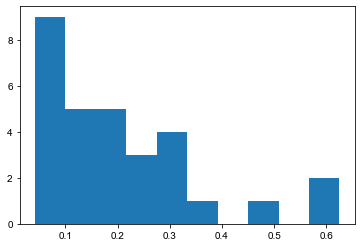

In [59]:
cccategory=nsdfallclust['Category'].tolist()
ccgeneralprocess=nsdfallclust['General Process'].tolist()

uniccgeneralprocess=[]
unicccategory=[]
for s in range(0,len(ccgeneralprocess)):
    if ccgeneralprocess[s] not in uniccgeneralprocess:
        uniccgeneralprocess.append(ccgeneralprocess[s])
    if cccategory[s] not in unicccategory:
        unicccategory.append(cccategory[s])

colnames=nsdfallclust.columns.tolist()[5:]
print(colnames)

haveclust=[0]*len(colnames)
for i in range(0,len(unicccategory)):
    dftmp=nsdfallclust[nsdfallclust['Category']==unicccategory[i]]
    #print(dftmp)
    for j in range(0,len(colnames)):
        tmplist=dftmp[colnames[j]].tolist()
        if 'Yes' in tmplist:
            haveclust[j]=haveclust[j]+1
            
print(haveclust)
haveclustfrac=[]
for i in range(0,len(colnames)):
    haveclustfrac.append(haveclust[i]/len(unicccategory))
print(haveclustfrac)

plt.bar(np.arange(0,numkclusts,1),haveclustfrac)

print(scipy.stats.binom_test(haveclust[26], 42, p=np.mean(haveclustfrac)))
print(scipy.stats.binom_test(haveclust[18], 42, p=np.mean(haveclustfrac)))

plt.figure()
plt.hist(haveclustfrac)


## 3.5 - Determine number of discreate processes with any 2 IDR cluster type

In [60]:
cccategory=nsdfallclust['Category'].tolist()
ccgeneralprocess=nsdfallclust['General Process'].tolist()

uniccgeneralprocess=[]
unicccategory=[]
for s in range(0,len(ccgeneralprocess)):
    if ccgeneralprocess[s] not in uniccgeneralprocess:
        uniccgeneralprocess.append(ccgeneralprocess[s])
    if cccategory[s] not in unicccategory:
        unicccategory.append(cccategory[s])

#colnames=nsdfallclust.columns.tolist()[5:]
allcolnames=nsdfallclust.columns.tolist()[5:]
subcolnames=['Cluster 18','Cluster 26']
colnames = [x for x in allcolnames if x not in subcolnames]
print(colnames)

haveclust=[0]*int(math.factorial(len(colnames))/(math.factorial(len(colnames)-2)*math.factorial(2)))
setnames=[]
print(len(haveclust))
for i in range(0,len(unicccategory)):
    dftmp=nsdfallclust[nsdfallclust['Category']==unicccategory[i]]
    #print(dftmp)
    count=-1
    for j in range(0,len(colnames)):
        for k in range(j+1,len(colnames)):
            count=count+1
            tmplist1=dftmp[colnames[j]].tolist()
            tmplist2=dftmp[colnames[k]].tolist()
            if i==0:
                setnames.append(colnames[j]+', '+colnames[k])
            #print(str(i)+': '+str(count))
            if 'Yes' in tmplist1 or 'Yes' in tmplist2:
                haveclust[count]=haveclust[count]+1
                
#print(haveclust)
print(max(haveclust))
print(np.mean(haveclust))

haveclustfrac=[]
for i in range(0,len(haveclust)):
    haveclustfrac.append(haveclust[i]/len(unicccategory))
print(np.mean(haveclustfrac))

print(len(setnames))
print(len(haveclustfrac))

['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'Cluster 12', 'Cluster 13', 'Cluster 14', 'Cluster 15', 'Cluster 16', 'Cluster 17', 'Cluster 19', 'Cluster 20', 'Cluster 21', 'Cluster 22', 'Cluster 23', 'Cluster 24', 'Cluster 25', 'Cluster 27', 'Cluster 28', 'Cluster 29']
378
16
7.243386243386244
0.3018077601410935
378
378


## 3.6 - Plot distribution of number of occurences

(-0.05, 1.05)

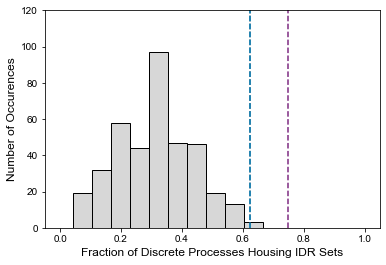

In [61]:
plt.hist(haveclustfrac,color='#d7d7d7',edgecolor='black')

mycolor=['#000000','#1d9bd7','#7c2880']
for i in range(0,len(haveclustmainfrac)):
    plt.plot([haveclustmainfrac[i],haveclustmainfrac[i]],[0,700],'--',color=mycolor[i])
    
plt.ylim([0,120])
plt.ylabel('Number of Occurences',fontsize=12)
plt.xlabel('Fraction of Discrete Processes Housing IDR Sets',fontsize=12)
plt.xlim([-0.05,1.05])

#plt.savefig('Figures/2024_02/speckles/Fraction_discrete_spliceosome_processes_housing_2_IDR_sets_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'.pdf', transparent=True, bbox_inches = "tight") 


## 3.7 - Save data to excel

In [62]:
setnames.append('Cluster 18')
setnames.append('Cluster 26')
setnames.append('Cluster 18, Cluster 26')

haveclustfracall=haveclustfrac.copy()
for i in range(0,len(haveclustmainfrac)):
    haveclustfracall.append(haveclustmainfrac[i])

print(len(haveclustfrac))
print(len(haveclustfracall))
    
tmpdf=pd.DataFrame()
tmpdf['Which Clusters']=setnames
tmpdf['Fraction of Processes']=haveclustfracall
print(tmpdf)

#with pd.ExcelWriter('../Supplementary_Tables/Table_S3.xlsx', engine='openpyxl',mode='a') as writer:
#    tmpdf.to_excel(writer,sheet_name='Fig_S3E')

378
381
             Which Clusters  Fraction of Processes
0      Cluster 0, Cluster 1               0.625000
1      Cluster 0, Cluster 2               0.333333
2      Cluster 0, Cluster 3               0.250000
3      Cluster 0, Cluster 4               0.250000
4      Cluster 0, Cluster 5               0.291667
..                      ...                    ...
376  Cluster 27, Cluster 29               0.416667
377  Cluster 28, Cluster 29               0.291667
378              Cluster 18               0.625000
379              Cluster 26               0.625000
380  Cluster 18, Cluster 26               0.750000

[381 rows x 2 columns]


# Part 4 - Analyze Transcriptional complex IDRs

## 4.1 - Determine if have cluster 10, 11, or 28 IDRs in each transcriptional complex protein

In [63]:
tcdf=pd.read_excel('data/Nucleoplasm_processes.xlsx',sheet_name='Nucleoplasm_processes')
print(tcdf)

tcdf2=pd.read_excel('data/Nucleoplasm_processes.xlsx',sheet_name='RNA_binding_motif')
print(tcdf2)

tcaccs=tcdf['Accession'].tolist()+tcdf2['Accession'].tolist()
print(len(tcaccs))

tcdffull=tcdf.append(tcdf2, ignore_index=True)

tchasIDR=[]
tcclustertypes=[]
tc10=[]
tc11=[]
tc28=[]
tc101128=[]
for s in range(0,len(tcaccs)):
    pos=[i for i, x in enumerate(subaccsNODIST) if x == tcaccs[s]]
    if not pos:
        tchasIDR.append('No')
        tc10.append('No')
        tc11.append('No')
        tc28.append('No')
        tc101128.append('No')
    else:
        tchasIDR.append('Yes')
        tmplist=[]
        for p in pos:
            tmplist.append(subclustersNODIST[p])
        #print(subgeneswnumsNODIST[p])
        #print(tmplist)
        
        if 10 in tmplist:
            tc10.append('Yes')
        else:
            tc10.append('No')
            
        if 11 in tmplist:
            tc11.append('Yes')
        else:
            tc11.append('No')
                        
        if 28 in tmplist:
            tc28.append('Yes')
        else:
            tc28.append('No')
            
        if 10 in tmplist or 11 in tmplist or 28 in tmplist:
            tc101128.append('Yes')
        else:
            tc101128.append('No')

tcdfwclust=tcdffull
tcdfwclust['IDR']=tchasIDR
tcdfwclust['Cluster 10']=tc10
tcdfwclust['Cluster 11']=tc11
tcdfwclust['Cluster 28']=tc28
tcdfwclust['Cluster 10, 11, or 28']=tc101128

print(tcdfwclust)

#tcdfwclust.to_excel('data/Nucleoplasm_processes_w_clusters_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'.xlsx')


    Accession   Gene                           General Process  \
0      P24863   CCNC  RNA polymerase II-mediated transcription   
1      P49336   CDK8  RNA polymerase II-mediated transcription   
2      Q9BWU1  CDK19  RNA polymerase II-mediated transcription   
3      Q15648   MED1  RNA polymerase II-mediated transcription   
4      Q9NX70  MED29  RNA polymerase II-mediated transcription   
..        ...    ...                                       ...   
269    Q04206   RELA                             Enhanceosomes   
270    P19838  NFKB1                             Enhanceosomes   
271    Q15788  NCOA1                 Histone modifying complex   
272    Q15596  NCOA2                 Histone modifying complex   
273    Q9Y6Q9  NCOA3                 Histone modifying complex   

                                           Category  \
0                                  Mediator complex   
1                                  Mediator complex   
2                                  Mediato

## 4.2 - Determine number of discreate processes with 10, 11, 28 or any

In [64]:
cccategory=tcdfwclust['Category'].tolist()
ccgeneralprocess=tcdfwclust['General Process'].tolist()

uniccgeneralprocess=[]
unicccategory=[]
for s in range(0,len(ccgeneralprocess)):
    if ccgeneralprocess[s] not in uniccgeneralprocess:
        uniccgeneralprocess.append(ccgeneralprocess[s])
    if cccategory[s] not in unicccategory:
        unicccategory.append(cccategory[s])
print(len(unicccategory))

colnames=['Cluster 10','Cluster 11','Cluster 28','Cluster 10, 11, or 28']
haveclustmain=[0]*len(colnames)
#print(haveclustmain)
for i in range(0,len(unicccategory)):
    dftmp=tcdfwclust[tcdfwclust['Category']==unicccategory[i]]
    #print(dftmp)
    for j in range(0,len(colnames)):
        tmplist=dftmp[colnames[j]].tolist()
        if 'Yes' in tmplist:
            haveclustmain[j]=haveclustmain[j]+1
            
print(haveclustmain)
haveclustmainfrac=[]
for i in range(0,len(colnames)):
    haveclustmainfrac.append(haveclustmain[i]/len(unicccategory))
print(haveclustmainfrac)

19
[13, 12, 8, 17]
[0.6842105263157895, 0.631578947368421, 0.42105263157894735, 0.8947368421052632]


## 4.3 - Determine which IDRs in each transcriptional complex protein

In [65]:
numkclusts=max(fullclusternum)+1

tcdf=pd.read_excel('data/Nucleoplasm_processes.xlsx',sheet_name='Nucleoplasm_processes')
print(tcdf)

tcdf2=pd.read_excel('data/Nucleoplasm_processes.xlsx',sheet_name='RNA_binding_motif')
print(tcdf2)

tcaccs=tcdf['Accession'].tolist()+tcdf2['Accession'].tolist()
print(len(tcaccs))

tcdffull=tcdf.append(tcdf2, ignore_index=True)

tchasIDR=[]
tcclustertypes=[]
tcc=[[] for _ in range(numkclusts)]
for s in range(0,len(tcaccs)):
    pos=[i for i, x in enumerate(subaccsNODIST) if x == tcaccs[s]]
    if not pos:
        tchasIDR.append('No')
        for i in range(0,numkclusts):
            tcc[i].append('No')
        
    else:
        tchasIDR.append('Yes')

        tmplist=[]
        for p in pos:
            tmplist.append(subclustersNODIST[p])
        #print(subgeneswnumsNODIST[p])
        #print(tmplist)
        
        for i in range(0,numkclusts):
            if i in tmplist:
                tcc[i].append('Yes')
            else:
                tcc[i].append('No')


tcdfallclust=tcdffull
tcdfallclust['IDR']=tchasIDR
for i in range(0,numkclusts):
    tcdfallclust['Cluster '+str(i)]=tcc[i]
    

print(tcdfallclust)

    Accession   Gene                           General Process  \
0      P24863   CCNC  RNA polymerase II-mediated transcription   
1      P49336   CDK8  RNA polymerase II-mediated transcription   
2      Q9BWU1  CDK19  RNA polymerase II-mediated transcription   
3      Q15648   MED1  RNA polymerase II-mediated transcription   
4      Q9NX70  MED29  RNA polymerase II-mediated transcription   
..        ...    ...                                       ...   
269    Q04206   RELA                             Enhanceosomes   
270    P19838  NFKB1                             Enhanceosomes   
271    Q15788  NCOA1                 Histone modifying complex   
272    Q15596  NCOA2                 Histone modifying complex   
273    Q9Y6Q9  NCOA3                 Histone modifying complex   

                                           Category  \
0                                  Mediator complex   
1                                  Mediator complex   
2                                  Mediato

## 4.4 - Determine number of discreate processes with each IDR cluster type

['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'Cluster 12', 'Cluster 13', 'Cluster 14', 'Cluster 15', 'Cluster 16', 'Cluster 17', 'Cluster 18', 'Cluster 19', 'Cluster 20', 'Cluster 21', 'Cluster 22', 'Cluster 23', 'Cluster 24', 'Cluster 25', 'Cluster 26', 'Cluster 27', 'Cluster 28', 'Cluster 29']
[4, 9, 4, 11, 12, 2, 10, 9, 4, 11, 13, 12, 10, 7, 13, 5, 8, 3, 10, 8, 7, 10, 1, 12, 9, 9, 1, 8, 8, 3]
[0.21052631578947367, 0.47368421052631576, 0.21052631578947367, 0.5789473684210527, 0.631578947368421, 0.10526315789473684, 0.5263157894736842, 0.47368421052631576, 0.21052631578947367, 0.5789473684210527, 0.6842105263157895, 0.631578947368421, 0.5263157894736842, 0.3684210526315789, 0.6842105263157895, 0.2631578947368421, 0.42105263157894735, 0.15789473684210525, 0.5263157894736842, 0.42105263157894735, 0.3684210526315789, 0.5263157894736842, 0.05263157894736842, 0.631578947368421,

(array([3., 2., 3., 1., 0., 6., 4., 4., 2., 5.]),
 array([0.05263158, 0.11578947, 0.17894737, 0.24210526, 0.30526316,
        0.36842105, 0.43157895, 0.49473684, 0.55789474, 0.62105263,
        0.68421053]),
 <BarContainer object of 10 artists>)

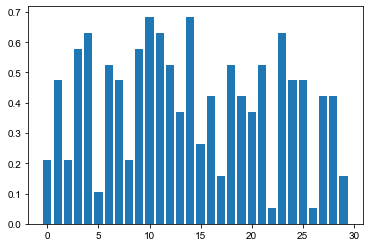

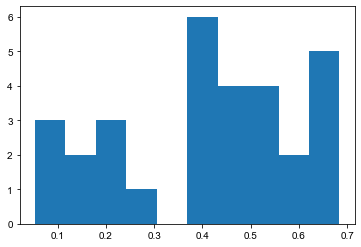

In [66]:
cccategory=tcdfallclust['Category'].tolist()
ccgeneralprocess=tcdfallclust['General Process'].tolist()

uniccgeneralprocess=[]
unicccategory=[]
for s in range(0,len(ccgeneralprocess)):
    if ccgeneralprocess[s] not in uniccgeneralprocess:
        uniccgeneralprocess.append(ccgeneralprocess[s])
    if cccategory[s] not in unicccategory:
        unicccategory.append(cccategory[s])

colnames=tcdfallclust.columns.tolist()[8:]
print(colnames)

haveclust=[0]*len(colnames)
for i in range(0,len(unicccategory)):
    dftmp=tcdfallclust[tcdfallclust['Category']==unicccategory[i]]
    #print(dftmp)
    for j in range(0,len(colnames)):
        tmplist=dftmp[colnames[j]].tolist()
        if 'Yes' in tmplist:
            haveclust[j]=haveclust[j]+1
            
print(haveclust)
haveclustfrac=[]
for i in range(0,len(colnames)):
    haveclustfrac.append(haveclust[i]/len(unicccategory))
print(haveclustfrac)

plt.bar(np.arange(0,numkclusts,1),haveclustfrac)

print(scipy.stats.binom_test(haveclust[10], len(unicccategory), p=np.mean(haveclustfrac)))
print(scipy.stats.binom_test(haveclust[11], len(unicccategory), p=np.mean(haveclustfrac)))
print(scipy.stats.binom_test(haveclust[28], len(unicccategory), p=np.mean(haveclustfrac)))

plt.figure()
plt.hist(haveclustfrac)


## 4.5 - Determine number of discreate processes with any 3 IDR cluster type

In [70]:
cccategory=tcdfallclust['Category'].tolist()
ccgeneralprocess=tcdfallclust['General Process'].tolist()

uniccgeneralprocess=[]
unicccategory=[]
for s in range(0,len(ccgeneralprocess)):
    if ccgeneralprocess[s] not in uniccgeneralprocess:
        uniccgeneralprocess.append(ccgeneralprocess[s])
    if cccategory[s] not in unicccategory:
        unicccategory.append(cccategory[s])

#colnames=tcdfallclust.columns.tolist()[8:]
allcolnames=tcdfallclust.columns.tolist()[8:]
subcolnames=['Cluster 10','Cluster 11','Cluster 28']
colnames = [x for x in allcolnames if x not in subcolnames]
print(colnames)

haveclust=[0]*int(math.factorial(len(colnames))/(math.factorial(len(colnames)-3)*math.factorial(3)))
print(len(haveclust))
setnames=[]
for i in range(0,len(unicccategory)):
    dftmp=tcdfallclust[tcdfallclust['Category']==unicccategory[i]]
    #print(dftmp)
    count=-1
    for j in range(0,len(colnames)):
        for k in range(j+1,len(colnames)):
            for l in range(k+1,len(colnames)):
                count=count+1
                tmplist1=dftmp[colnames[j]].tolist()
                tmplist2=dftmp[colnames[k]].tolist()
                tmplist3=dftmp[colnames[l]].tolist()
                if i==0:
                    setnames.append(colnames[j]+', '+colnames[k]+', '+colnames[l])
                #print(str(i)+': '+str(count))
                if 'Yes' in tmplist1 or 'Yes' in tmplist2 or 'Yes' in tmplist3:
                    haveclust[count]=haveclust[count]+1
                
#print(haveclust)
print(max(haveclust))
print(np.mean(haveclust))

haveclustfrac=[]
for i in range(0,len(haveclust)):
    haveclustfrac.append(haveclust[i]/len(unicccategory))
print(np.mean(haveclustfrac))

print(len(haveclustfrac))
print(len(setnames))

['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 12', 'Cluster 13', 'Cluster 14', 'Cluster 15', 'Cluster 16', 'Cluster 17', 'Cluster 18', 'Cluster 19', 'Cluster 20', 'Cluster 21', 'Cluster 22', 'Cluster 23', 'Cluster 24', 'Cluster 25', 'Cluster 26', 'Cluster 27', 'Cluster 29']
2925
18
13.25025641025641
0.6973819163292847
2925
2925


## 4.6 - Plot number of occurrences

(-0.05, 1.05)

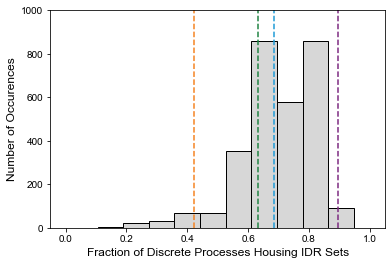

In [71]:
plt.hist(haveclustfrac,color='#d7d7d7',edgecolor='black')

mycolor=['#1d9bd7','#1f8241','#f58220','#7c2880']
for i in range(0,len(haveclustmainfrac)):
    plt.plot([haveclustmainfrac[i],haveclustmainfrac[i]],[0,1000],'--',color=mycolor[i])
    
plt.ylim([0,1000])
plt.ylabel('Number of Occurences',fontsize=12)
plt.xlabel('Fraction of Discrete Processes Housing IDR Sets',fontsize=12)
plt.xlim([-0.05, 1.05])
#plt.savefig('Figures/2024_02/nucleoplasm/Fraction_discrete_nucleoplasm_processes_housing_3_IDR_sets_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'.pdf', transparent=True, bbox_inches = "tight") 


## 4.7 - Save data to excel file

In [72]:
setnames.append('Cluster 10')
setnames.append('Cluster 11')
setnames.append('Cluster 28')
setnames.append('Cluster 10, Cluster 11, Cluster 28')

haveclustfracall=haveclustfrac.copy()
for i in range(0,len(haveclustmainfrac)):
    haveclustfracall.append(haveclustmainfrac[i])

print(len(haveclustfrac))
print(len(haveclustfracall))
    
tmpdf=pd.DataFrame()
tmpdf['Which Clusters']=setnames
tmpdf['Fraction of Processes']=haveclustfracall
print(tmpdf)

#with pd.ExcelWriter('../Supplementary_Tables/Table_S5.xlsx', engine='openpyxl',mode='a') as writer:
#    tmpdf.to_excel(writer,sheet_name='Fig_S5E')

2925
2929
                          Which Clusters  Fraction of Processes
0        Cluster 0, Cluster 1, Cluster 2               0.578947
1        Cluster 0, Cluster 1, Cluster 3               0.736842
2        Cluster 0, Cluster 1, Cluster 4               0.789474
3        Cluster 0, Cluster 1, Cluster 5               0.473684
4        Cluster 0, Cluster 1, Cluster 6               0.684211
...                                  ...                    ...
2924  Cluster 26, Cluster 27, Cluster 29               0.473684
2925                          Cluster 10               0.684211
2926                          Cluster 11               0.631579
2927                          Cluster 28               0.421053
2928  Cluster 10, Cluster 11, Cluster 28               0.894737

[2929 rows x 2 columns]
